In [1]:
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-w7nfhdzj
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-w7nfhdzj
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0b6c19867d6ef4ef69f6ed5688eaf92c4a3145b79_-cp36-none-any.whl size=139117 sha256=c0a3bc5d33a896c783075fa9b85f4af5ed832d79ac3e418a6d5fbe3fdde956c5
  Stored in directory: /tmp/pip-ephem-wheel-cache-aszermm6/wheels/eb/1b/35/fce87697be00d2fc63e0b4b395b0d9c7e391a10e98d9a0d97f
Successfully built tensorflow-docs


In [2]:
import numpy as np
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.interpolate import griddata
import numpy.ma as ma
from numpy.random import uniform, seed, multivariate_normal
from matplotlib import cm


from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

plt.style.use('seaborn')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Density Estimation

In [3]:
# Sample from a multivariate gaussian distribution
mean = np.array([0,0])
cov = np.array([[3,2],[2,6]])
normal = multivariate_normal(mean, cov, 100000)

In [4]:
df_normal = pd.DataFrame({'x':normal[:,0], 'y':normal[:,1]})
df_normal = df_normal[(df_normal['x'] >= 0) & (df_normal['y'] >= 0)]
df_normal['label'] = 1

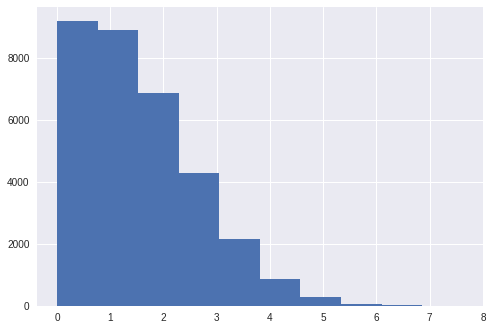

In [5]:
df_normal['x'].hist()

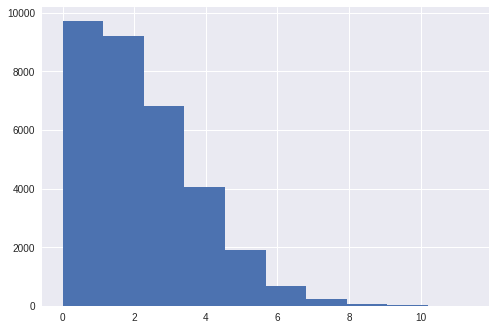

In [6]:
df_normal['y'].hist()

In [7]:
# Sample from a uniform distribution

n = 200
xy_min = [0, 0]
xy_max = [10, 20]
anomaly = uniform(low=xy_min, high=xy_max, size=(n,2))

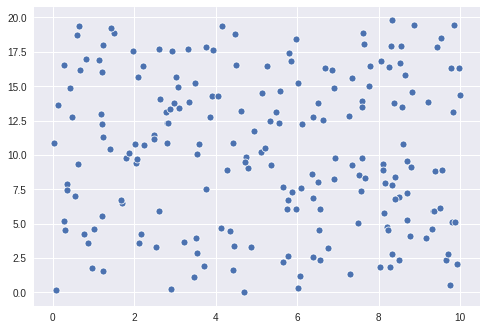

In [8]:
sns.scatterplot(anomaly[:,0], anomaly[:,1])

In [9]:
df_anomaly = pd.DataFrame({'x':anomaly[:,0], 'y':anomaly[:,1]})
df_anomaly['label'] = 0

## Combine the two samples

In [10]:
df = pd.concat([df_normal, df_anomaly])
# df = df[(df.x>=0) & (df.y>=0)]

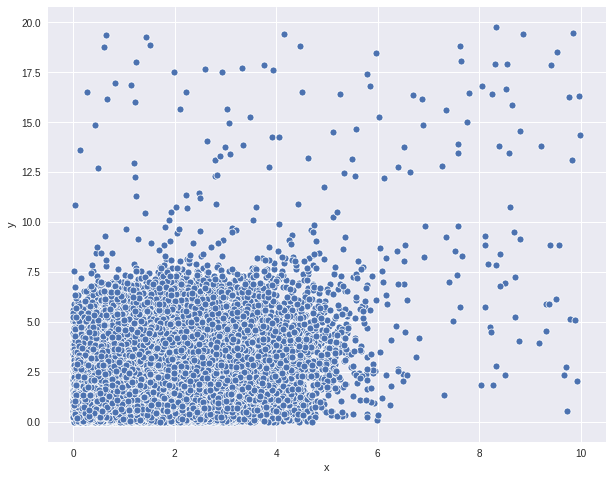

In [11]:
plt.figure(figsize=(10,8))
g = sns.scatterplot(df['x'], df['y'])
# g.set(xlim=(0,12),ylim=(0,20))

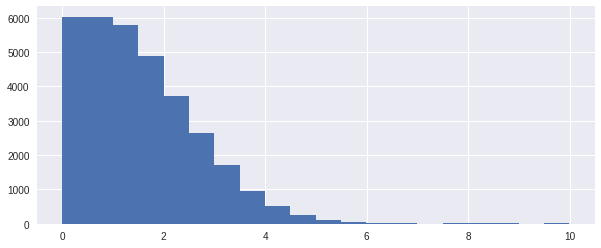

In [12]:
plt.figure(figsize=(10,4))

df.x.hist(bins=20)

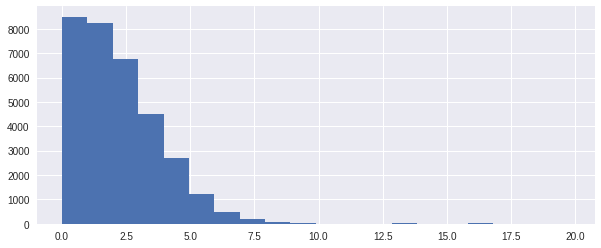

In [13]:
plt.figure(figsize=(10,4))

df.y.hist(bins=20)

In [14]:
mu_estimated = np.mean(df[['x','y']].values, axis=0)

In [15]:
mu_estimated

array([1.57276539, 2.24195566])

In [16]:
cov_estimated = np.cov(df[['x','y']].values.T)

In [17]:
cov_estimated

array([[1.33006515, 0.58857923],
       [0.58857923, 2.97706204]])

## Plot the Count

In [18]:
def gauss(x, y, mu, Sigma):
    """
    Compute the density of a multivariate Gaussian distribution
    """
    X = np.vstack((x,y)).T
    mat_multi = np.dot((X - mu).dot(np.linalg.inv(Sigma)),(X - mu).T)
    return  1/math.pi * 1/(np.sqrt(np.linalg.det(Sigma))) * np.diag(np.exp(-1/2*(mat_multi)))

(0.0, 10.0)

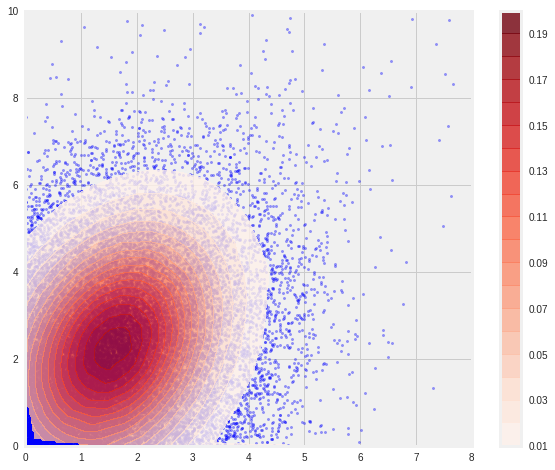

In [19]:
# make up some randomly distributed data
npts = 5000
x = uniform(0, 12, npts)
y = uniform(0, 20, npts)
z = gauss(x, y, mu=mu_estimated, Sigma=cov_estimated)

plt.figure(figsize=(10,8))
plt.style.use("fivethirtyeight")

# define grid.
xi = np.linspace(-2, 13, 500)
yi = np.linspace(-2, 21, 500)

## grid the data.
zi = griddata((x, y), z, (xi.reshape(1, xi.shape[0]), yi.reshape(yi.shape[0], 1)))

levels = np.array(range(1, 21))*0.01

# contour the gridded data, plotting dots at the randomly spaced data points.
plt.scatter(df.x, df.y, marker='o', c='b', s=5, alpha=0.4)

CS = plt.contourf(xi, yi, zi, len(levels), cmap=plt.get_cmap("Reds"), levels=levels, alpha=0.8)
plt.colorbar() # draw colorbar

# plot data points.
plt.xlim(0, 8)
plt.ylim(0, 10)

## Density Estimation example 2

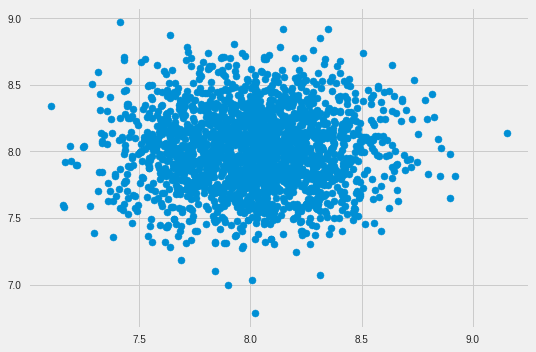

In [20]:
import random
random.seed(13)
data, _ = make_blobs(n_samples=2000, centers=1, cluster_std=0.3, center_box=(8, 8))

plt.scatter(data[:,0], data[:,1])
plt.show()

In [21]:
mu_estimated = data.mean(axis=0)
mu_estimated

cov_estimated = np.cov(data.T)
cov_estimated

array([[0.08716171, 0.00013961],
       [0.00013961, 0.09116169]])

(6.0, 9.0)

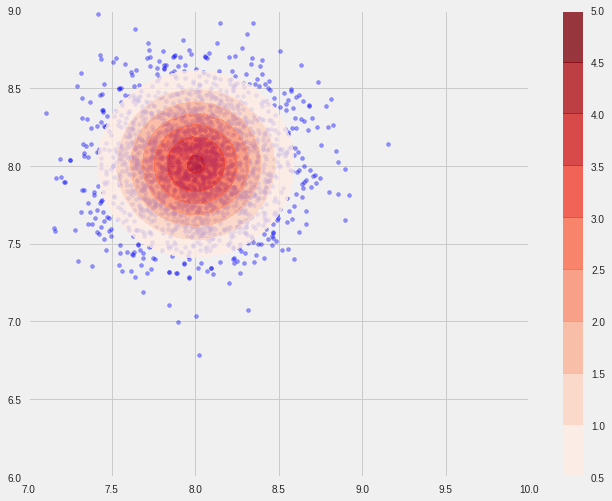

In [22]:
# make up some randomly distributed data
npts = 5000
x = uniform(np.floor(min(data[:,0])), np.ceil(max(data[:,0])), npts)
y = uniform(np.floor(min(data[:,1])), np.ceil(max(data[:,1])), npts)
z = gauss(x, y, mu=mu_estimated, Sigma=cov_estimated)

plt.figure(figsize=(10,8))
plt.style.use("fivethirtyeight")

# define grid.
xi = np.linspace(np.floor(min(data[:,0])), np.ceil(max(data[:,0])), 500)
yi = np.linspace(np.floor(min(data[:,1])), np.ceil(max(data[:,1])), 500)

## grid the data.
zi = griddata((x, y), z, (xi.reshape(1, xi.shape[0]), yi.reshape(yi.shape[0], 1)))

levels = np.array(range(1, 11))*0.5

# contour the gridded data, plotting dots at the randomly spaced data points.
plt.scatter(data[:,0], data[:,1], marker='o', c='b', s=15, alpha=0.4)

CS = plt.contourf(xi, yi, zi, len(levels), cmap=plt.get_cmap("Reds"), levels=levels, alpha=0.8)
plt.colorbar() # draw colorbar

# plot data points.
plt.xlim(np.floor(min(data[:,0])), np.ceil(max(data[:,0])))
plt.ylim(np.floor(min(data[:,1])), np.ceil(max(data[:,1])))

# K-means Clustering

<Figure size 720x576 with 0 Axes>

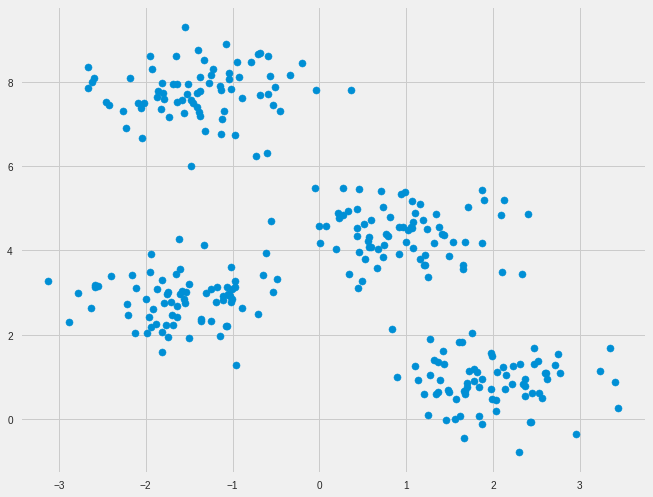

In [23]:
X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)
plt.figure(figsize=(10,8))
plt.figure(figsize=(10,8))
plt.scatter(X[:, 0], X[:, 1], s=50)


In [24]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

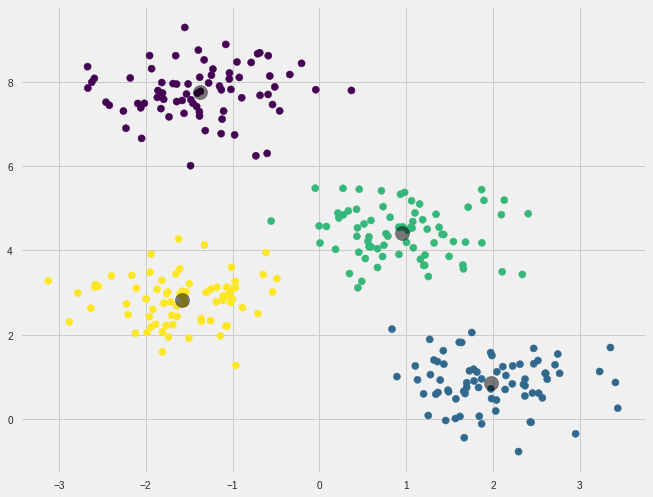

In [25]:
plt.figure(figsize=(10,8))
plt.style.use("fivethirtyeight")
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

## Visualization for one iteration

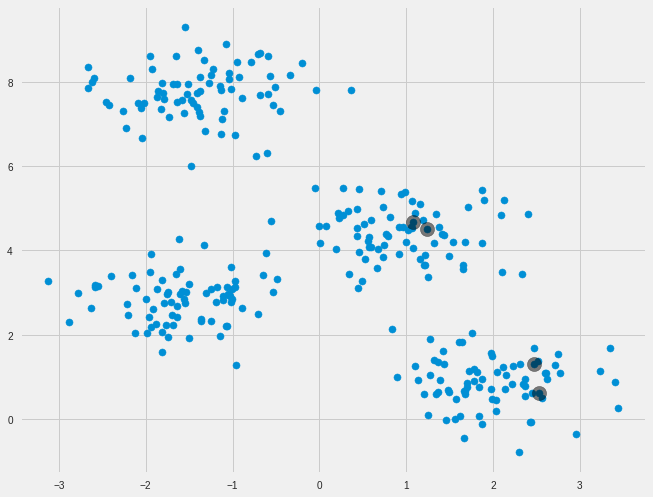

In [26]:
n_clusters = 4

# 1. Randomly choose clusters
rng = np.random.RandomState(0)
i = rng.permutation(X.shape[0])[:n_clusters]
centers = X[i]

plt.figure(figsize=(10,8))
plt.scatter(X[:, 0], X[:, 1], s=50)
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)


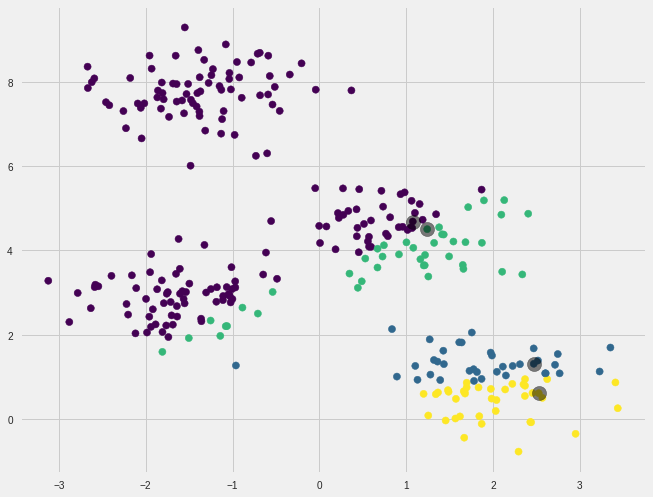

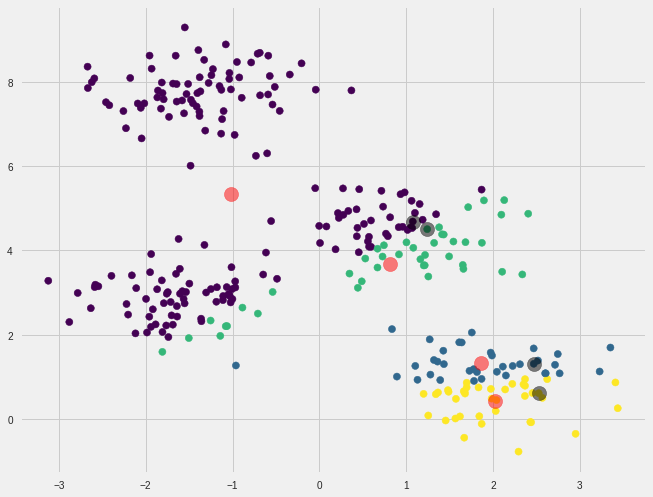

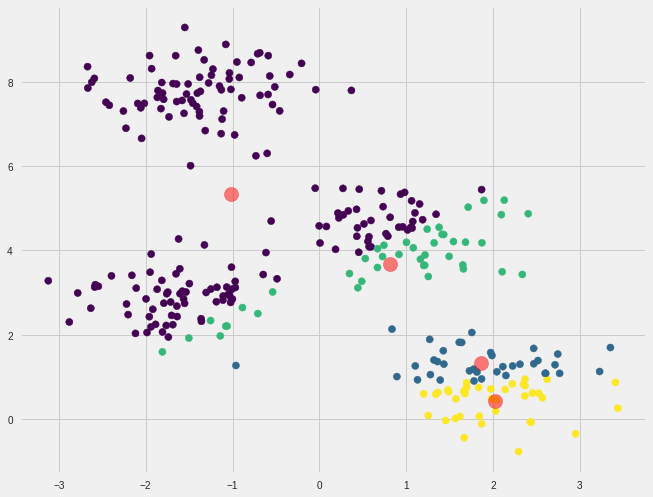

In [27]:
# 2a. Assign labels based on closest center
labels = pairwise_distances_argmin(X, centers)
 
plt.figure(figsize=(10,8))
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

# 2b. Find new centers from means of points
new_centers = np.array([X[labels == i].mean(0) for i in range(n_clusters)])
plt.figure(figsize=(10,8))
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
plt.scatter(new_centers[:, 0], new_centers[:, 1], c='red', s=200, alpha=0.5)


plt.figure(figsize=(10,8))
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis')
plt.scatter(new_centers[:, 0], new_centers[:, 1], c='red', s=200, alpha=0.5)

## Implement K-means clustering using expectation maximization

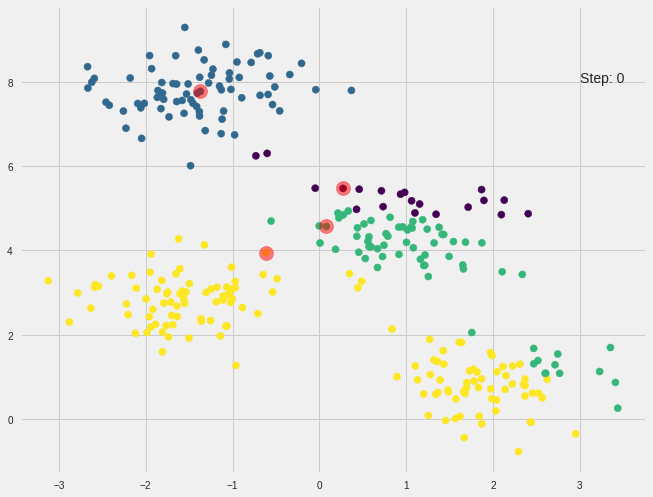

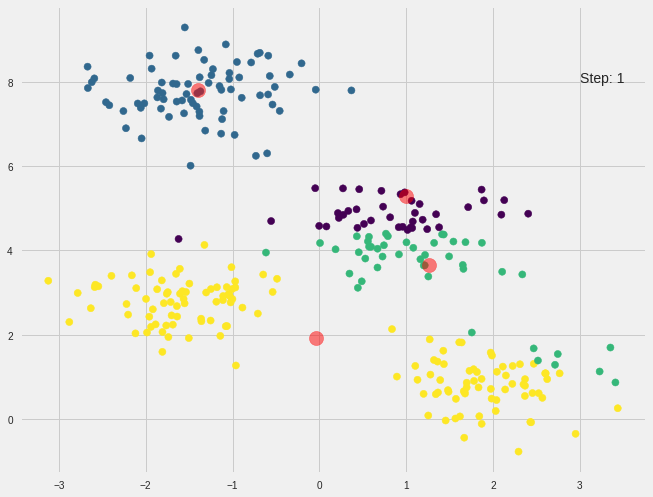

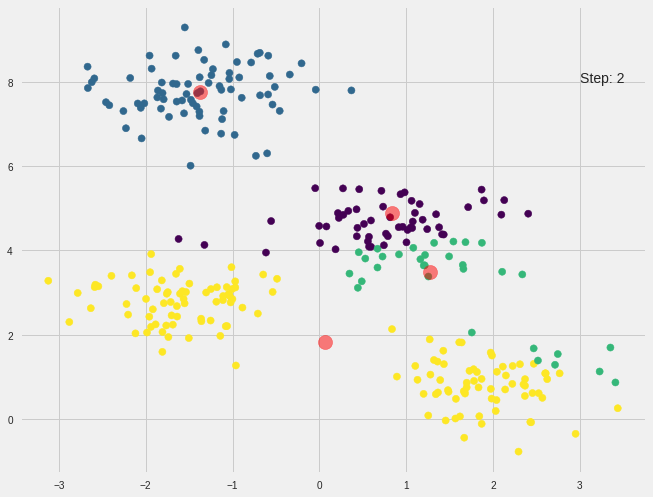

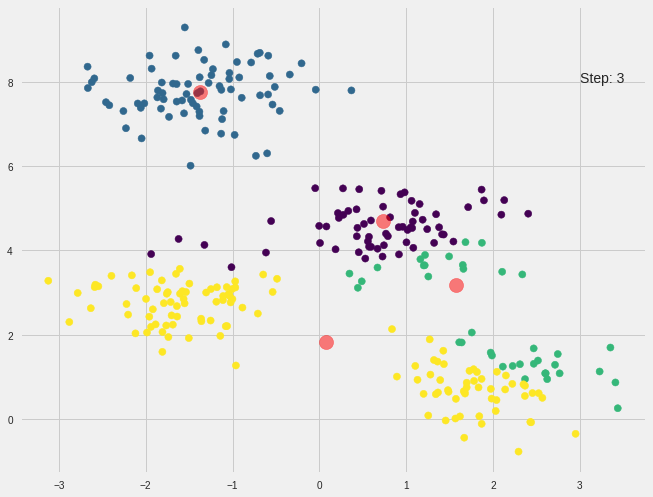

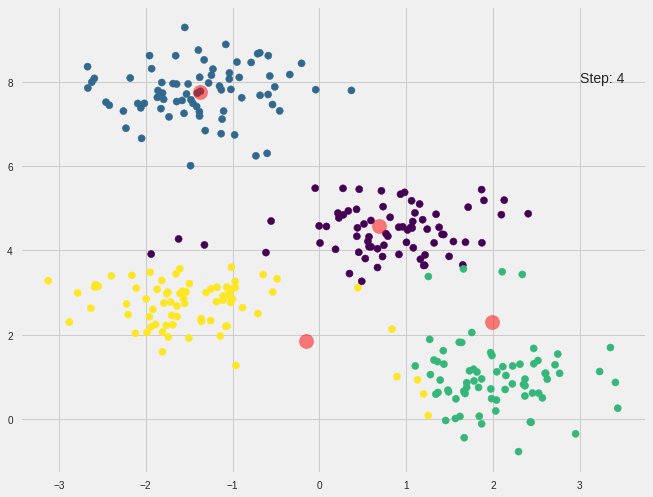

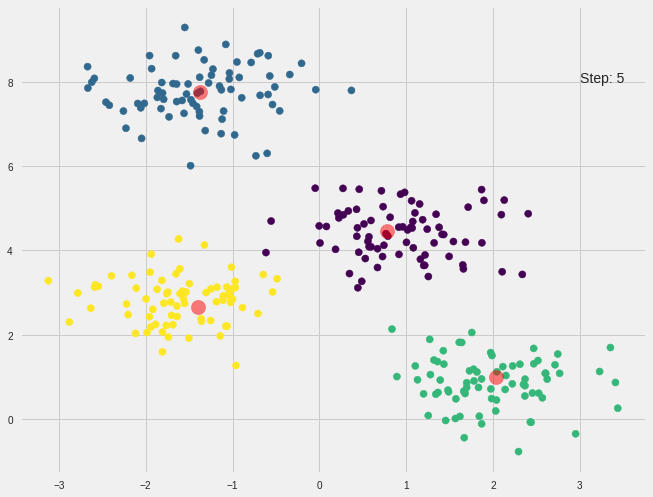

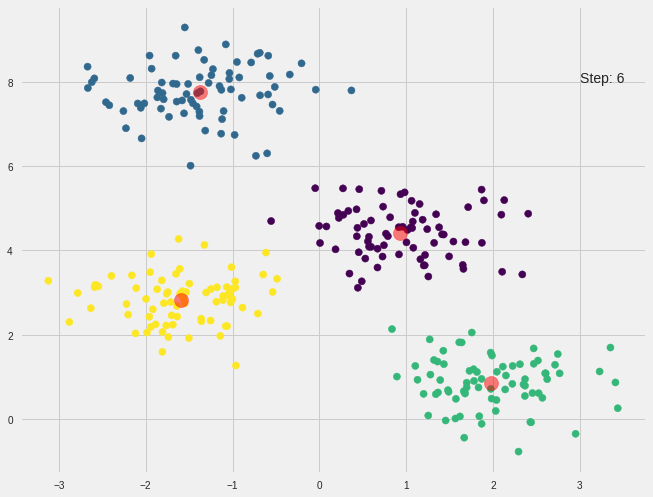

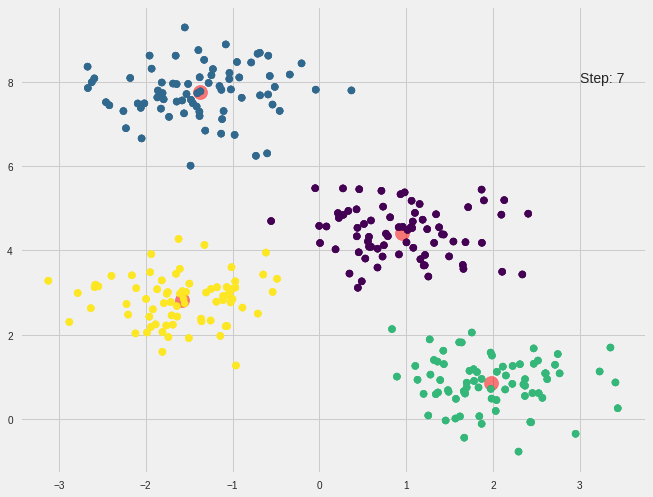

In [28]:

def find_clusters(X, n_clusters, rseed=2):
    # 1. Randomly choose clusters
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]
    
    count = 0
    while True:
        # 2a. Assign labels based on closest center
        labels = pairwise_distances_argmin(X, centers)
        
        plt.figure(figsize=(10,8))
        plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis')
        plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.5)
        plt.text(3, 8, f'Step: {count}')
        plt.savefig(f'step:{count}.png')
        
        # 2b. Find new centers from means of points
        new_centers = np.array([X[labels == i].mean(0)
                                for i in range(n_clusters)])
        
        # 2c. Check for convergence
        if np.all(centers == new_centers):
            break
        centers = new_centers
        
        count += 1
    return centers, labels, count

centers, labels, count = find_clusters(X, 4)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

In [29]:
import glob
import imageio

anim_file = 'kmeans.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('step*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)


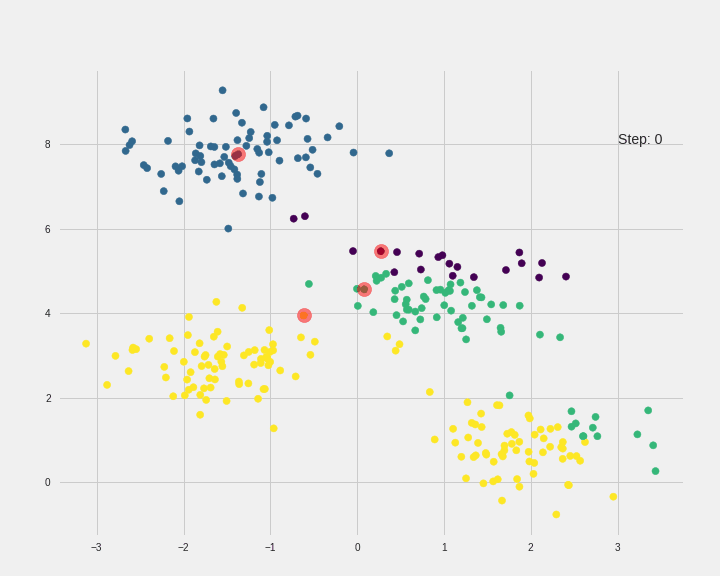

In [30]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

## Elbow method to determine the optimal number of clusters

In [31]:
 kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 0,
 }

# A list holds the SSE values for each k
sse = []

for k in range(1, 11):
  kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
  kmeans.fit(X)
  sse.append(kmeans.inertia_)

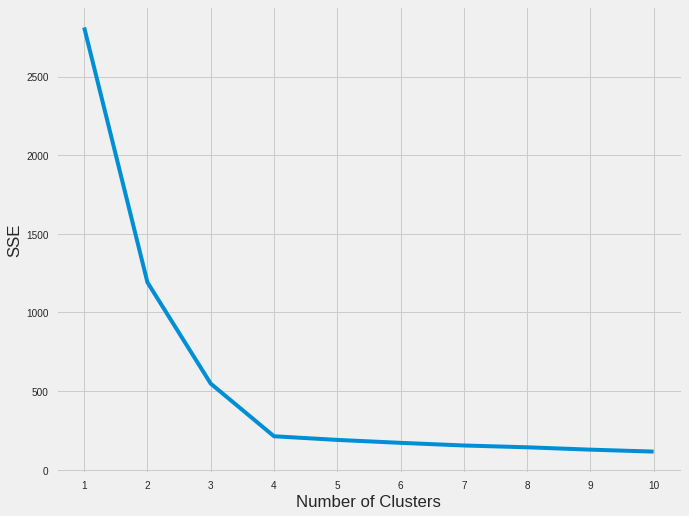

In [32]:
plt.figure(figsize=(10,8))

plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

## Agglomerative Clustering

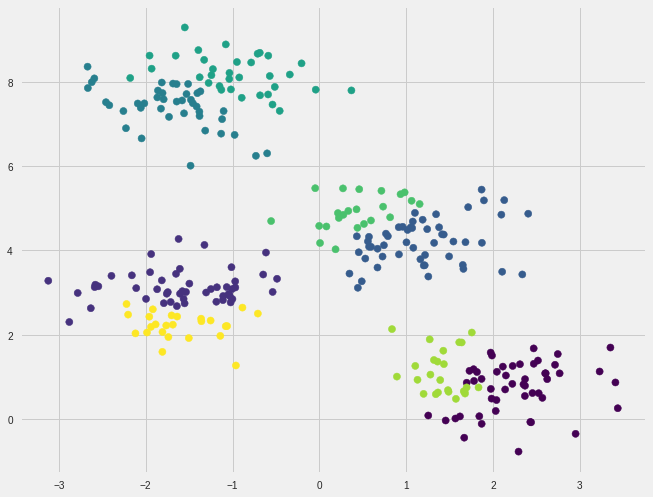

In [33]:
from sklearn.cluster import AgglomerativeClustering
plt.figure(figsize=(10,8))

clustering = AgglomerativeClustering(n_clusters=8).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=clustering, s=50, cmap='viridis')

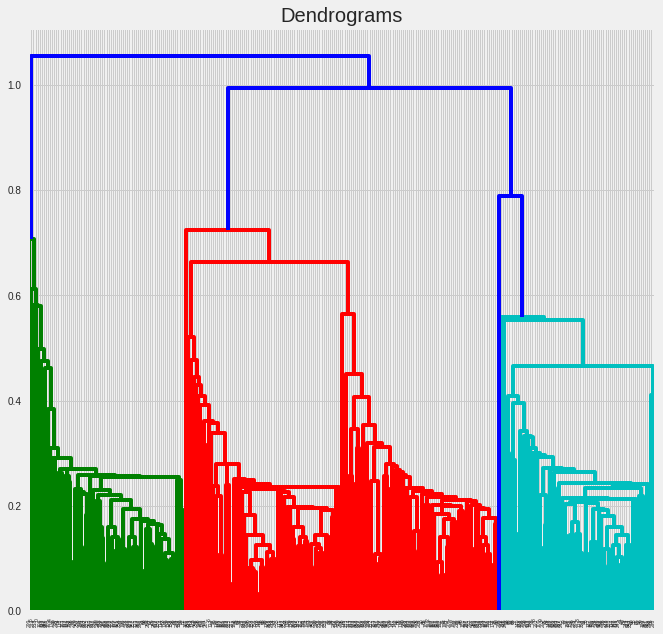

In [34]:
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(10, 10))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(X, method='single'))


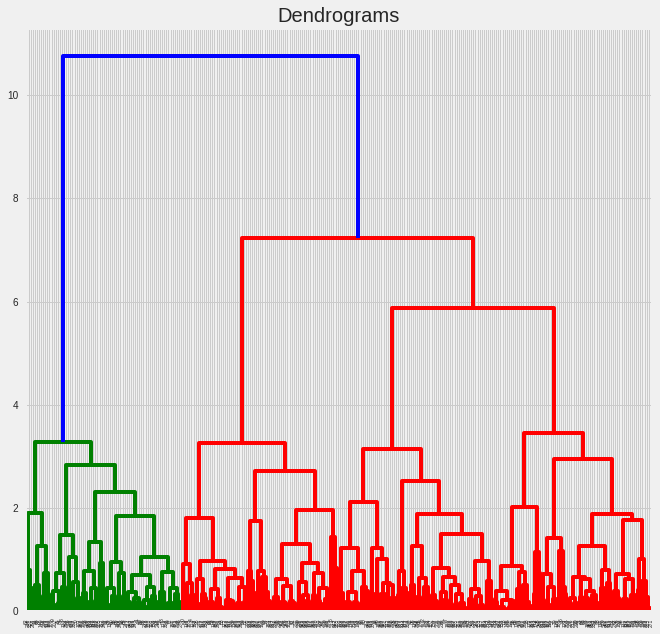

In [35]:

plt.figure(figsize=(10, 10))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(X, method='complete'))

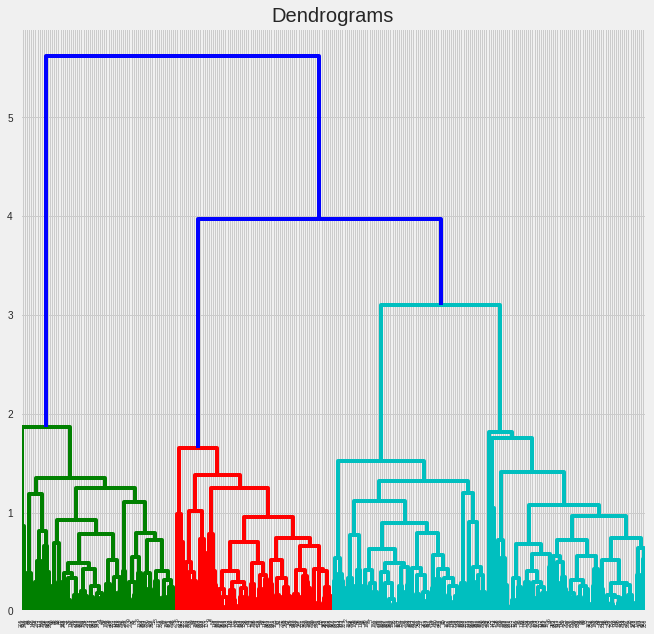

In [36]:

plt.figure(figsize=(10, 10))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(X, method='average'))

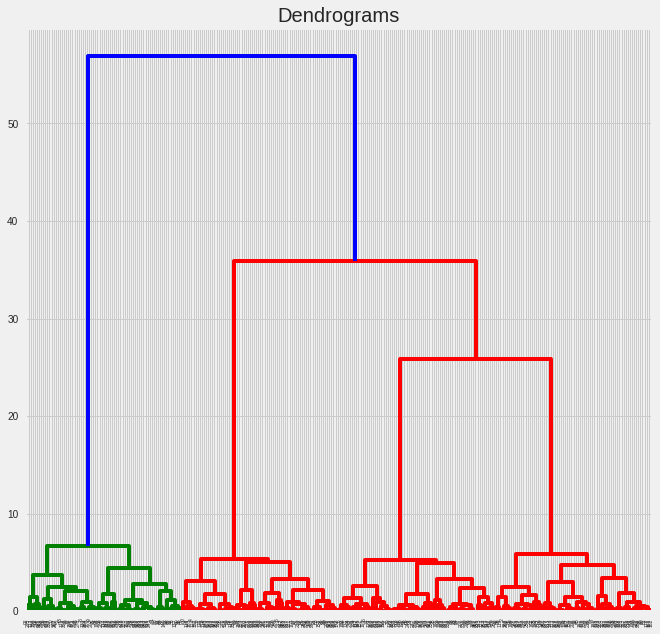

In [37]:

plt.figure(figsize=(10, 10))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(X, method='ward'))

## Self-organizing Map
A self-organizing map (SOM) is an unsupervised learning algorithm that allows users to visualize and cluster high-dimensional data on a low-dimensional grid of neurons. 

In [38]:
from sklearn.datasets import load_iris
iris_data = load_iris()

X = iris_data.data
y = iris_data.target

In [39]:
def closest_node(x, map):
    """
    Find the closest node in the map 
    x: the current data point to search for
    map: SOM
    """
    # (row,col) of map node closest to data[t]
    result = (0,0)
    small_dist = 1.0e20

    for i in range(len(map)):
        for j in range(len(map[0])):
            ed = euc_dist(map[i][j], x)
            if  small_dist > ed:
                # relaxation
                small_dist = ed
                result = (i, j)
    return result

def euc_dist(v1, v2):
    return np.linalg.norm(v1 - v2) 

def manhattan_dist(r1, c1, r2, c2):
    return np.abs(r1-r2) + np.abs(c1-c2)

def most_common(lst, n):
    """
    Find the most common value in the lst
    """
    # lst is a list of values 0 . . n
    if len(lst) == 0: 
        return -1
    
    counts = np.zeros(shape=n, dtype=np.int)

    for i in range(len(lst)):
        counts[lst[i]] += 1

    return np.argmax(counts)

In [40]:
Dim = X.shape[1]
Rows, Cols = 30, 30

RangeMax = Rows + Cols # maximum of the Manhattan distance

LearnMax = 0.5 # maximum learning rate
StepsMax = 3000 # maximum step

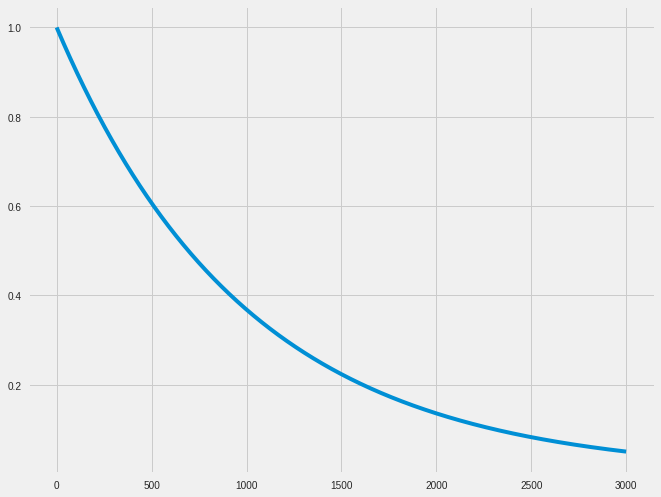

In [41]:
# Check the decay function

x = np.array(range(StepsMax))
A = 0.001

y1 = np.exp(-A*x)
plt.figure(figsize=(10,8))
plt.plot(x, y1)

In [42]:
# 2. construct the SOM
print("Constructing a 30x30 SOM from the iris data")

# This is a 30 by 30 map, where each location is a 4 dimensional vector that will be learned.
map = np.random.random_sample(size=(Rows,Cols,Dim))

for s in range(StepsMax):
    if s % (StepsMax/10) == 0: 
        print("step = ", str(s))
        
    # To decay the learning rate
    pct_left = 1.0 - ((s * 1.0) / StepsMax)
    curr_range = (int)(pct_left * RangeMax)

    # curr_rate = pct_left * LearnMax
    curr_rate = np.exp(-A * s)

    
    t = np.random.randint(len(X))

    # find the best matching unit
    bmu_row, bmu_col = closest_node(X[t], map)
    
    # Update the neighbors
    for i in range(Rows):
        for j in range(Cols):
            # only update the nodes in the neighbourhood
            if manhattan_dist(bmu_row, bmu_col, i, j) < curr_range:

                # Update the neuron representation
                map[i][j] = map[i][j] + curr_rate * (X[t] - map[i][j]) 

print("SOM construction complete \n")

Constructing a 30x30 SOM from the iris data
step =  0
step =  300
step =  600
step =  900
step =  1200
step =  1500
step =  1800
step =  2100
step =  2400
step =  2700
SOM construction complete 



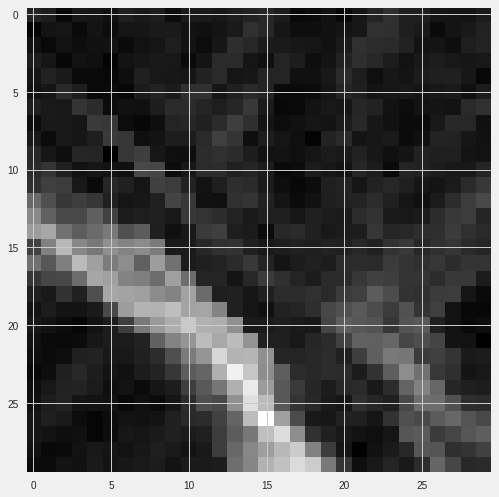

In [43]:
# 3. construct U-Matrix

# u_matrix stores the similarity scores for each vector learned in SOM with its neighbors. 
u_matrix = np.zeros(shape=(Rows,Cols), dtype=np.float64)

for i in range(Rows):
    for j in range(Cols):
        # the vector located at position (i, j) in the map
        v = map[i][j]       

        sum_dists = 0.0
        ct = 0
        if i-1 >= 0:          # above
            sum_dists += euc_dist(v, map[i-1][j]); ct += 1
        if i+1 <= Rows-1:     # below
            sum_dists += euc_dist(v, map[i+1][j]); ct += 1
        if j-1 >= 0:          # left
            sum_dists += euc_dist(v, map[i][j-1]); ct += 1
        if j+1 <= Cols-1:     # right
            sum_dists += euc_dist(v, map[i][j+1]); ct += 1

        u_matrix[i][j] = sum_dists / ct

# display U-Matrix
plt.figure(figsize=(10,8))

plt.imshow(u_matrix, cmap='gray')    # black = close = clusters
plt.show()

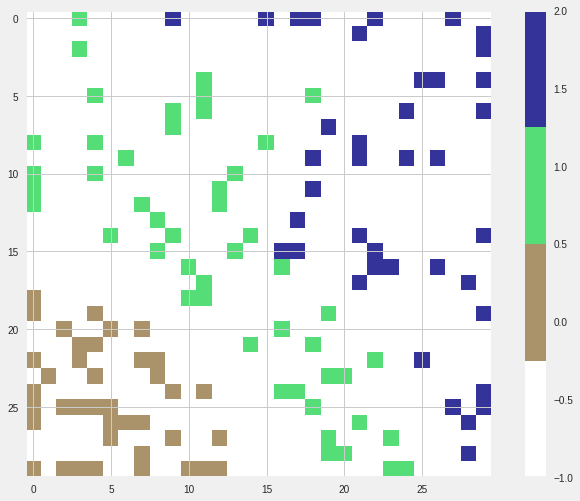

In [44]:
# 4. because the data has labels, another possible visualization:
# associate each data label with a map node

# mapping is a matrix of list, where each location contains a list of labels of elements that are closest to them
mapping = np.empty(shape=(Rows,Cols), dtype=object)

for i in range(Rows):
    for j in range(Cols):
        mapping[i][j] = []

for t in range(len(X)):
    m_row, m_col = closest_node(X[t], map)
    mapping[m_row][m_col].append(y[t])

label_map = np.zeros(shape=(Rows,Cols), dtype=np.int)

for i in range(Rows):
    for j in range(Cols):
        label_map[i][j] = most_common(mapping[i][j], 3)

plt.figure(figsize=(10,8))
plt.imshow(label_map, cmap=plt.cm.get_cmap('terrain_r', 4))
plt.colorbar()
plt.show()

## Support Vector Machine
### Margins of different C

In [45]:
from sklearn import datasets, svm

def my_linspace (min_value, max_value, steps):
    """
    Returns evenly spaced samples, calculated over the interval [min_value - 0.1 * (max_value - min_value), max_value + 0.1 * (max_value - min_value)].
    """
    diff = max_value - min_value
    return np.linspace (min_value - 0.1 * diff, max_value + 0.1 * diff, steps)

def my_line (x1_min, 
             x1_max, 
             x2_min, 
             x2_max, 
             w, 
             b):
    """
    Generate a line segment. 
    w[0] * x1 + w[1] * x2 + b = 0
    """
    if w[0] == 0.0:
        if w[1] == 0.0:
            print('impossible line')
            return [0.0, 0.0], [0.0, 0.0]
        else:
            # Horizontal line: w[1] * x2 + b = 0 => x2 = -b/w[1]
            # Two two end points are: (x1_min, -b/w[1]) and (x1_max, -b/w[1])
            return [x1_min, x1_max], [- b / w[1], - b / w[1]]
    elif w[1] == 0.0:
            # Vertical line: w[0] * x1  + b = 0 => x1 = -b/w[0]
            # The two end points are: (-b/w[0], x2_min) and (-b/w[0], x2_max)
            return [- b / w[0], - b / w[0]], [x2_min, x2_max]
    else:
        # General case
        # x2 = (-w[0] * x1 + b) / w[1]
        xn = - (w[1] * np.asarray([x2_min, x2_max]) + b)  / w[0]
        x1_min, x1_max = max(x1_min, min(xn)), min(x1_max, max(xn))
        return [x1_min, x1_max], [- (w[0] * x1_min + b) / w[1], - (w[0] * x1_max + b) / w[1]]

In [53]:
iris = datasets.load_iris()

X = iris.data[:100,:2]
y = iris.target[:100]

In [54]:
clf = []
for C in [1, 10, 100, 1000]:
    clf.append(svm.SVC(kernel = 'linear', C=C))
for i in range(4):
    clf[i].fit(X, y)

In [55]:
steps = 200
x0 = my_linspace(min(X[:,0]), max(X[:,0]), steps)
x1 = my_linspace(min(X[:,1]), max(X[:,1]), steps)
xx0, xx1 = np.meshgrid(x0, x1)
mesh_data = np.c_[xx0.ravel(), xx1.ravel()]
mesh_deci = [0] * 4
for i in range(4):
    mesh_deci[i] = clf[i].decision_function(mesh_data).reshape(steps, steps)

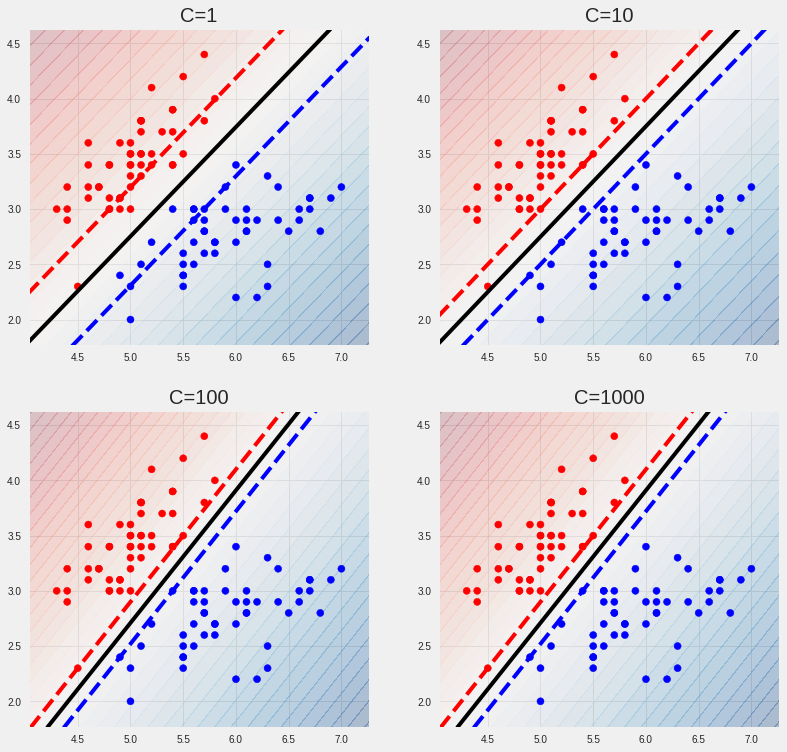

In [56]:
color = ['red', 'blue']
y_color = [color[i] for i in y]

plt.figure(figsize = (12, 12))
contour_color = [plt.cm.Reds, plt.cm.Blues]

for i in range(4):
    plt.subplot(2, 2, i+1)
    div = my_line(x0[0], x0[-1], x1[0], x1[-1], clf[i].coef_[0], clf[i].intercept_[0])
    pos = my_line(x0[0], x0[-1], x1[0], x1[-1], clf[i].coef_[0], clf[i].intercept_[0] - 1)
    neg = my_line(x0[0], x0[-1], x1[0], x1[-1], clf[i].coef_[0], clf[i].intercept_[0] + 1)
    plt.plot(div[0], div[1], color='black')
    plt.plot(pos[0], pos[1], color='blue', ls='--')
    plt.plot(neg[0], neg[1], color='red', ls='--')
    plt.contourf(xx0, xx1, np.maximum(-mesh_deci[i], 0.0), 20, cmap=contour_color[0], alpha=0.3)
    plt.contourf(xx0, xx1, np.maximum(mesh_deci[i], 0.0), 20, cmap=contour_color[1], alpha=0.3)
    plt.scatter(X[:,0], X[:,1], c=y_color)
    plt.title(f'C={pow(10, i)}')

plt.show()

## SVM binary classification with kernels

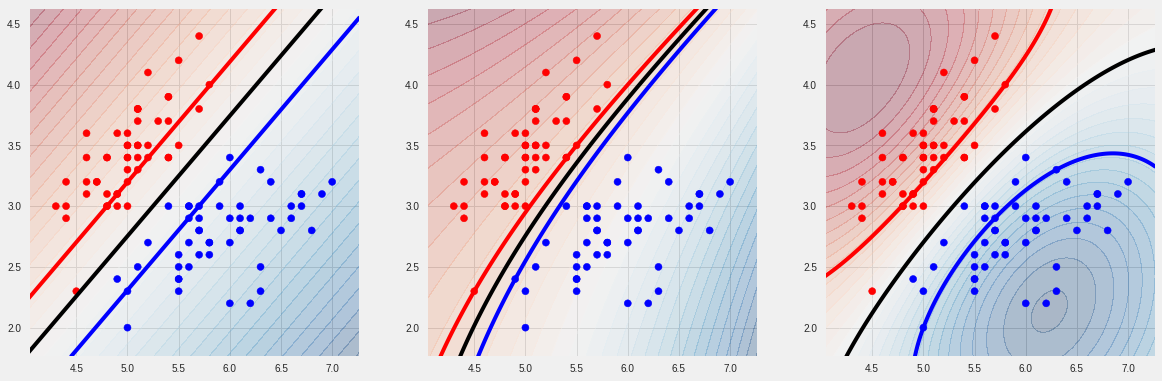

In [57]:
clf = []
for kern in ['linear', 'poly', 'rbf']:
    clf.append(svm.SVC(kernel=kern))

for i in range(len(clf)):
    clf[i].fit(X, y)
    
steps = 200
x0 = my_linspace(min(X[:,0]), max(X[:,0]), steps)
x1 = my_linspace(min(X[:,1]), max(X[:,1]), steps)
xx0, xx1 = np.meshgrid(x0, x1)
mesh_data = np.c_[xx0.ravel(), xx1.ravel()]
mesh_deci = [0] * 3

for i in range(3):
    mesh_deci[i] = clf[i].decision_function(mesh_data).reshape(steps, steps)

plt.figure(figsize = (18, 6))
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.contourf(xx0, xx1, mesh_deci[i], 40, cmap=plt.cm.RdBu, alpha=0.3)
    plt.contour(xx0, xx1, mesh_deci[i], levels=[-1.0,0.0,1.0], colors=['red','black','blue'])
    plt.scatter(X[:,0], X[:,1], c=y_color)

plt.show()

## One-class SVM

In [58]:
from sklearn.svm import OneClassSVM
from sklearn.datasets import make_blobs
from numpy import quantile, where, random

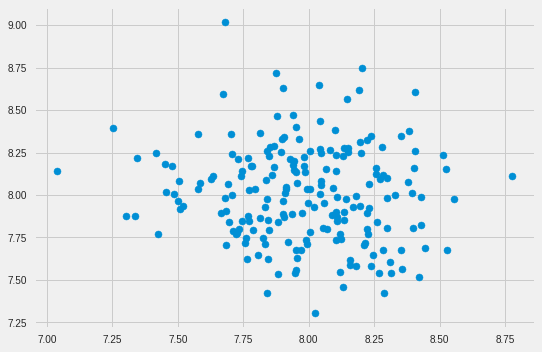

In [59]:
random.seed(13)
x, _ = make_blobs(n_samples=200, centers=1, cluster_std=.3, center_box=(8, 8))

plt.scatter(x[:,0], x[:,1])
plt.show()

In [60]:
svm = OneClassSVM(kernel='rbf', gamma=0.001, nu=0.03)
svm.fit(x)
pred = svm.predict(x)

anom_index = where(pred==-1)
values = x[anom_index]


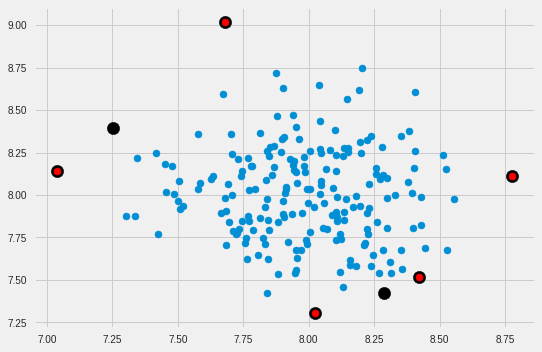

In [61]:
support_vectors = svm.support_vectors_

plt.scatter(x[:,0], x[:,1])
plt.scatter(support_vectors[:,0], support_vectors[:,1], s=150, color='black')
plt.scatter(values[:,0], values[:,1], color='r')
plt.show()


In [62]:
svm = OneClassSVM(kernel='rbf', gamma=0.001, nu=0.02)
pred = svm.fit_predict(x)
scores = svm.score_samples(x)
thresh = quantile(scores, 0.1)
index = where(scores <= thresh)
values = x[index]

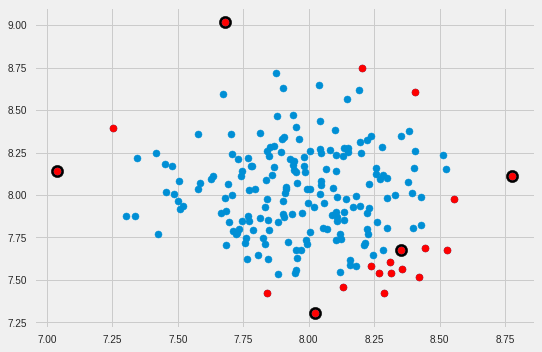

In [63]:
support_vectors = svm.support_vectors_
plt.scatter(support_vectors[:,0], support_vectors[:,1], s=150, color='black')
plt.scatter(x[:,0], x[:,1])
plt.scatter(values[:,0], values[:,1], color='r')
plt.show()
